In [1]:
import sys
#!{sys.executable} -m pip install sklearn
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib
import random
import os
from matplotlib import animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import spatial
from IPython.display import HTML
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel)

import importlib
import scripts.theodolite_function as tfu
import scripts.theodolite_utils as tfuu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import scripts.gp_prediction_utils as GPf
GPf = importlib.reload(GPf)
import GPy

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
# Switch values if necessary 1 11 2021
#Dist_prism_12 = 1.0398341231585624*1000
#Dist_prism_13 = 0.818424700118086*1000
#Dist_prism_23 = 0.8806156053859284*1000
#Dist_GPS_12 = 0.835637436093363*1000
#Dist_GPS_13 = 0.7812173648662254*1000
#Dist_GPS_23 = 0.5166745729506486*1000

# 26 11 2021
#Dist_prism_12 = 1.03688797895733
#Dist_prism_13 = 0.822536135483593
#Dist_prism_23 = 0.8783765747673403
#Dist_GPS_12 = 0.7828618536473139
#Dist_GPS_13 = 0.8394208131018045
#Dist_GPS_23 = 0.5176447366930409

# 31 01 2022
#Dist_prism_12 = 1.038854051807371
#Dist_prism_13 = 0.8202157646292075
#Dist_prism_23 = 0.879788333022114
#Dist_GPS_12 = 0.7830826912858335
#Dist_GPS_13 = 0.8418404054627937
#Dist_GPS_23 = 0.5172558618541933
     
# 03 02 2022
#Dist_prism_12 = 1.0403741344089559
#Dist_prism_13 = 0.8239475424257701
#Dist_prism_23 = 0.8766711748547112
#Dist_GPS_12 = 0.781661929058067
#Dist_GPS_13 = 0.8353981332464246
#Dist_GPS_23 = 0.5174987476948135

# 17 02 2022
Dist_prism_12 = 0.8882613537922258
Dist_prism_13 = 0.8262903370535766
Dist_prism_23 = 1.0377436460567973
Dist_GPS_12 = 0.7809786915630756
Dist_GPS_13 = 0.8378323585433202
Dist_GPS_23 = 0.5191788936274444   

In [4]:
tfuu = importlib.reload(tfuu)
path = "./data/gps/20220217/"
gps_front = np.array(tfuu.read_gps_point_processed(path+"gpsfront.csv"))
gps_back = np.array(tfuu.read_gps_point_processed(path+"gpsback.csv"))
gps_middle = np.array(tfuu.read_gps_point_processed(path+"gpsmiddle.csv"))

gps_dist_12 = np.array(tfuu.read_gps_distance_processed(path+"gps12_distance.csv"))
gps_dist_13 = np.array(tfuu.read_gps_distance_processed(path+"gps13_distance.csv"))
gps_dist_23 = np.array(tfuu.read_gps_distance_processed(path+"gps23_distance.csv"))

<IPython.core.display.Javascript object>


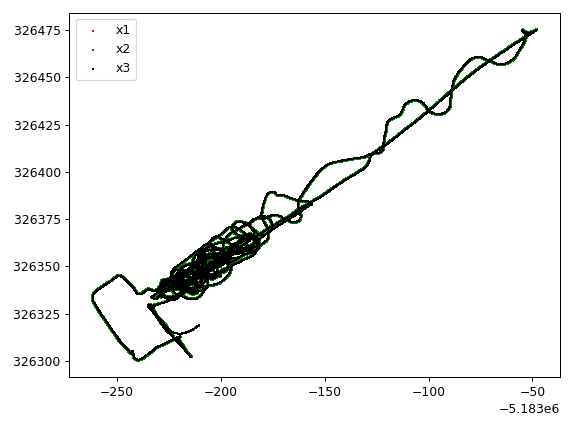

In [6]:
%matplotlib notebook
plt.figure(0)
coord = 0
start = 1000
stop = -400
plt.scatter(-gps_front[start:stop,coord+1], gps_front[start:stop,coord+2], label="x1", marker="+", s = 1, color="red")
plt.scatter(-gps_back[start:stop,coord+1], gps_back[start:stop,coord+2], label="x2", marker="+", s = 1, color="green")
plt.scatter(-gps_middle[start:stop,coord+1], gps_middle[start:stop,coord+2], label="x3", marker="+", s = 1, color="black")

ax = plt.gca()
#ax.set_yscale('symlog')
plt.legend(loc='best')
#ax.set_ylim([0, 100])
#plt.savefig("./figs/20211116_trajectory.jpg")
plt.show()    

<IPython.core.display.Javascript object>


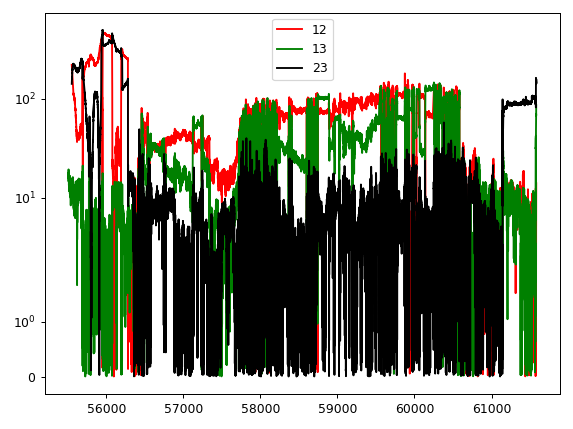

In [7]:
%matplotlib notebook
plt.figure(0)
coord = 0
start = 1000
stop = -400
plt.plot(gps_dist_12[start:stop,coord], abs(gps_dist_12[start:stop,coord+1]-np.ones_like(gps_dist_12[start:stop,coord+1])*Dist_GPS_12)*1000, label="12", color="red")
plt.plot(gps_dist_13[start:stop,coord], abs(gps_dist_13[start:stop,coord+1]-np.ones_like(gps_dist_13[start:stop,coord+1])*Dist_GPS_13)*1000, label="13", color="green")
plt.plot(gps_dist_23[start:stop,coord], abs(gps_dist_23[start:stop,coord+1]-np.ones_like(gps_dist_23[start:stop,coord+1])*Dist_GPS_23)*1000, label="23", color="black")

ax = plt.gca()
ax.set_yscale('symlog')
plt.legend(loc='best')
#ax.set_ylim([0, 100])
plt.show()  

49.522485820474444 36.692379362189016 13.440000667051837
35.78589415076436 33.103456957614895 24.016262036910135


<IPython.core.display.Javascript object>


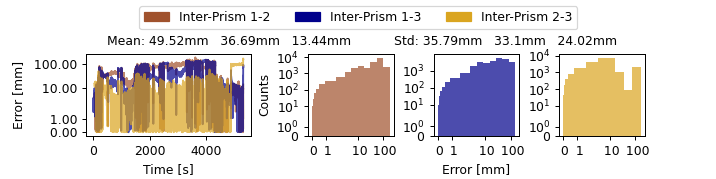

 /home/norlab/python-env/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning:`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
 /home/norlab/Repo_git/code_publication_IROS2022_MaximeVaidis/scripts/theodolite_plot_function.py:1317: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [19]:
%matplotlib notebook
import scripts.theodolite_plot_function as ptfu
ptfu = importlib.reload(ptfu)
start = 4700
stop = -400
save_fig = True
name_file = "./figs/20220217.jpg"
ptfu.subplot_prisms_error_gt(gps_dist_12[start:stop,0], gps_dist_13[start:stop,0], gps_dist_23[start:stop,0], abs(gps_dist_12[start:stop,1]-Dist_GPS_12)*1000, abs(gps_dist_13[start:stop,1]-Dist_GPS_13)*1000, abs(gps_dist_23[start:stop,1]-Dist_GPS_23)*1000, save_fig, name_file)